# First Practical Work

## Data Science and Engineering

### DESIGN OF AN IMAGE FILTER FUNCTION, PARALLELIZABLE AND SCALABLE

## Authors:

**Full name:** Mireia Alba Kesti Izquierdo 
    
**NIA**:** 100406960

**Full name:** Aleksandra Jamróz
    
**NIA**:** 100491363

Python multiprocessing documentation https://docs.python.org/3/library/multiprocessing.html

In [37]:
import numpy as np
import multiprocessing as mp
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile
import ctypes

In [38]:
# loading our own module
import myfunctions as my
import importlib
importlib.reload(my)

from myfunctions2 import tonumpyarray

### Image preparation 

First we have to take care about our image. Choose the file, open it, convert to numpy array and check the dimentions.

In [39]:
# defining the images for filtering
chess_file = "chess.jpg"
digits_file = "digits.jpg"
fence_file = "fence.jpg"
hand_x_ray_file = "hand-x-ray.jpg"
jupiter_file = "cloudsonjupi.jpg"

# opening chosen file
F_IMAGE = Image.open(chess_file)

# defining cmap (default is color image, if it's grayscale, cmap is changed later)
cmap = None

In [40]:
# get some information about the image
print(F_IMAGE.format)
print(F_IMAGE.size)
print(F_IMAGE.mode)

JPEG
(216, 233)
RGB


In [41]:
# load the image & convert it to numpy array
image = np.array(F_IMAGE)

# check that the image was converted into numpy array correctly
print(type(image))

<class 'numpy.ndarray'>


In [42]:
# checking if image is gray-scale, changing cmap and expanding one dimention if necessary
if len(image.shape) == 2:
    cmap = "gray"
    image = np.expand_dims(image, axis=2)

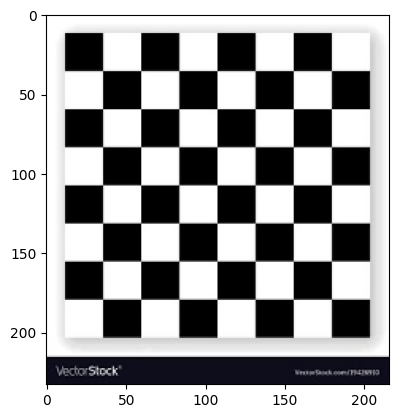

In [43]:
# visualise the picture
plt.figure()
plt.imshow(image, cmap=cmap)

In [44]:
# get the value of each pixel of the numpy array image
print(image)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 14  13  27]
  [ 14  13  27]
  [ 14  13  27]
  ...
  [ 12  11  25]
  [ 16  15  29]
  [ 13  12  26]]

 [[ 13  12  26]
  [ 13  12  26]
  [ 12  11  25]
  ...
  [ 16  15  29]
  [ 13  12  26]
  [ 13  12  26]]

 [[ 14  13  27]
  [ 14  13  27]
  [ 14  13  27]
  ...
  [ 14  13  27]
  [ 14  13  27]
  [ 14  13  27]]]


### Definitions of filters
* The first filter is impulse response filter (the image output must be equal to the original one).
* The second filter is an edge filter, first order in x axis,  
* The third filter is an edge filter, first order in y axis,
* the fourth filter is an edge filter, second order, bi-directional
* the fifth filter is a blur gausian filter.

In [45]:
# definitions of 5 available filters as numpy arrays

filter1 = np.array([[0,0,0,0,0],
                    [0,0,0,0,0],
                    [0,0,1,0,0],
                    [0,0,0,0,0],
                    [0,0,0,0,0]])

filter2 = np.array([[0.5, 0 , -0.5]])

filter3 = np.array([[0.5],[0],[-0.5]])

filter4 = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])

filter5 = np.array([[0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
                    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
                    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
                    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
                    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]])

### Preparation for filtering

In order to filter the image, we have to define some variables: how many processes we want to start, how much space will each of filtered image take and then define shared spaces in which our filtered images will be stored.

In [46]:
# setting the number of processes
NUMPROCESS = 8

In [47]:
# calculating data size to allocate in memory for filtered image
data_buffer_size = image.shape[0] * image.shape[1] * image.shape[2]
print("Size of the image: ", data_buffer_size)


Size of the image:  150984


In [48]:
# defining multiprocessing vectors (shared spaces)
filtered_image1_VECTOR = mp.Array(ctypes.c_byte, data_buffer_size)
filtered_image2_VECTOR = mp.Array(ctypes.c_byte, data_buffer_size)

### Applying 1 filter

Let's check if filtering function implemented in first separate module works correctly. We will run it on an image with one filter and see the result.

In [49]:
my.image_filter(image, filter2, NUMPROCESS, filtered_image1_VECTOR)  

In [50]:
filtered_image1 = tonumpyarray(filtered_image1_VECTOR).reshape(image.shape)

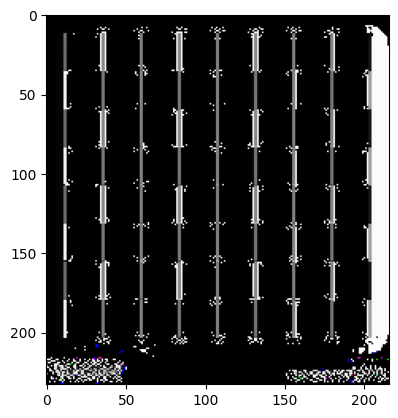

In [51]:
plt.figure()
plt.imshow(filtered_image1, cmap=cmap)

As we see, it works correctly. Now we can move to the second part.

### Applying 2 filters

Here you can find a function which filters 1 image with 2 filters at the same time. Filtering functions are in the separate modules in order to create  separate memory spaces. Definitions of them can be found in myfunctions module and myfunctions2 file.

In [52]:
def filters_execution(image: np.array,  
                      filter_mask1: np.array, 
                      filter_mask2: np.array,  
                      numprocessors: int,
                      filtered_image1: mp.Array,
                      filtered_image2: mp.Array ):
    """
    Function invoking 2 different parallel processes, each executing a filter
    on the same image and saving the result to independent memory spaces. Uses
    previous function for filtering.
    """

    # creating two processes
    p1 = mp.Process(target = my.image_filter, args = (image, filter_mask1, numprocessors, filtered_image1))
    p2 = mp.Process(target = my.image_filter, args = (image, filter_mask2, numprocessors, filtered_image2))
    
    # starting processes 
    p1.start() 
    p2.start() 
  
    # wait until processes are finished 
    p1.join() 
    p2.join()

    return

In [53]:
# Filters execution with chosen filters
filters_execution(image, filter3, filter4, NUMPROCESS, filtered_image1_VECTOR, filtered_image2_VECTOR)

### Visualization
Here we take the filtered images stored in the multiprocessing.Vector variables filtered_image1_VECTOR and filtered_image2_VECTOR, convert to numpy array, with the same shape of the orginal image, and show the results.

In [54]:
filtered_image1 = tonumpyarray(filtered_image1_VECTOR).reshape(image.shape)
filtered_image2 = tonumpyarray(filtered_image2_VECTOR).reshape(image.shape)

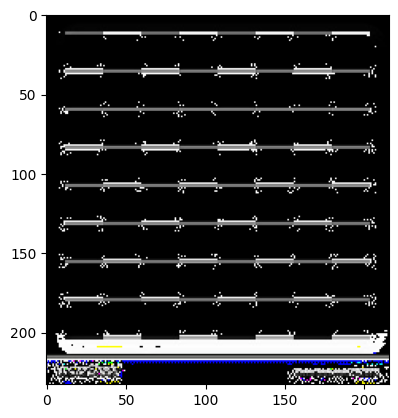

In [55]:
plt.figure()
plt.imshow(filtered_image1, cmap=cmap)

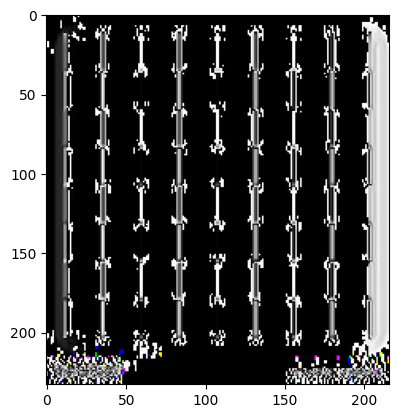

In [56]:
plt.figure()
plt.imshow(filtered_image2, cmap=cmap)

## Conclusion
We have harnessed the power of parallelization to apply filters to our image. When we execute using a single thread, we are (often) not making the best use of our available resources, i.e., we are often not taking full advantage of them, leaving them unused. 
Thus, by using thread pools, we can maximize the number of parallel tasks, increasing the efficiency of our program. 
Furthermore, it is important to include locks in order to handle memory access and avoid races, which we want to avoid. 

In the second task, when we are applying both filters simultaneously, we have to split the resources available, so that these tasks can run concurrently. Here, the limitations of our hardware (physical devices) is magnified, because each process can use only half of the available resources. In my case, as my computer only has 2 cores, the impact is larger. This highlights the importance of matching the software to the available hardware. Even the "best" or most "efficient" code, will not be optimal for any hardware. 